In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


<h1>MULTI-LAYER PERCEPTRON NEURAL NETWORK V1</h1>

inspiration: A Neural Probabilistic Language Model, Yoshua Bengio

character-level language model

initial implementation

In [2]:
# read in words 
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build vocab and map to/grom integers
characters = sorted(list(set(''.join(words))))
string_to_index = {string:index + 1 for index, string in enumerate(characters)}
string_to_index['.'] = 0
index_to_string = {index: string for string, index in string_to_index.items()}

In [4]:
# build the dataset
block_size = 3 # context length: characters used to predcit next one

def build_dataset(words):
    X, Y = [], []
    for word in words:

        # print(word)
        context = [0] * block_size
        for character in word + '.':
            index = string_to_index[character]
            X.append(context)
            Y.append(index)
            # print(''.join(index_to_string[i] for i in context), '--->', index_to_string[index])
            context = context[1:] + [index] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'input shape: {X.shape}')
    print(f'output shape: {Y.shape}') # dataset
    return X, Y

import random
random.seed(42)
random.shuffle(words)
partition1 = int(0.8*len(words))
partition2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:partition1])
X_development, Y_development = build_dataset(words[partition1:partition2])
X_test, Y_test = build_dataset(words[partition2:])


input shape: torch.Size([182625, 3])
output shape: torch.Size([182625])
input shape: torch.Size([22655, 3])
output shape: torch.Size([22655])
input shape: torch.Size([22866, 3])
output shape: torch.Size([22866])


neural net construction

In [5]:
# training data
print(f'input shape: {X_train.shape}')
print(f'output shape: {Y_train.shape}')

input shape: torch.Size([182625, 3])
output shape: torch.Size([182625])


In [6]:
generator = torch.Generator().manual_seed(2147483647)

# embedding lookup table ( 27 characters into 2-dim space)
C = torch.randn((27, 10), generator = generator) # C is lookup matrix for input layer (linear)

# weight and bias initialization
W1 = torch.randn((30, 200), generator = generator) # (dimension of inputs(three 2 dim inputs), neurons(100))
b1 = torch.randn(200, generator = generator)

W2 = torch.randn((200, 27), generator = generator)
b2 = torch.randn(27, generator = generator)

parameters = [C, W1, b1, W2, b2]

In [7]:
print(f'number of parameters: {str(sum(parameter.nelement() for parameter in parameters))}')

number of parameters: 11897


In [8]:
for parameter in parameters:
    parameter.requires_grad = True

In [9]:
loss_index = []
step_index = []

In [10]:
for current_iteration in range(50000):

    # minibatch construct
    minibatch_index = torch.randint(0, X_train.shape[0], (64,))

    # forward pass
    embeded_inputs = C[X_train[minibatch_index]] # (32, 3, 10)
    h = torch.tanh((embeded_inputs.view(-1, 30) @ W1) + b1) # (64, 200)
    print(h.shape)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[minibatch_index]) # exponentiates logits, finds probability for each (softmax), then finds negative log likelyhood

    # backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    #update step
    learning_rate = 0.01 if current_iteration < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # track stats 
    loss_index.append(loss.log10().item())
    step_index.append(current_iteration)


    

    # print(f'loss = {loss} after {current_iteration} iterations')


torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size([64, 200])
torch.Size

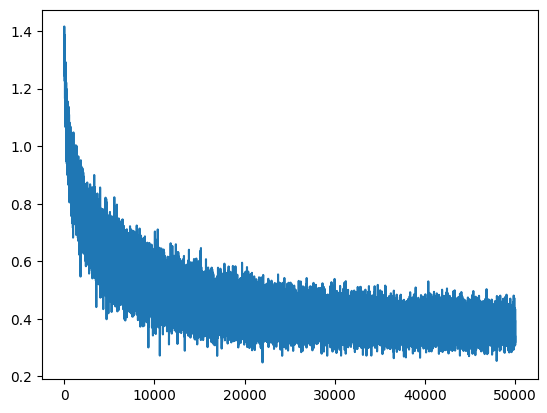

In [91]:
plt.plot(step_index, loss_index)

In [92]:
loss.item()

2.1785240173339844

In [93]:
embeded_inputs = C[X_train] # (32, 3, 2)
h = torch.tanh((embeded_inputs.view(-1, 30) @ W1) + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train) # exponentiates logits, finds probability for each (softmax), then finds negative
loss.item()

2.387718439102173

In [94]:
embeded_inputs = C[X_development] # (32, 3, 2)
h = torch.tanh((embeded_inputs.view(-1, 30) @ W1) + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_development) # exponentiates logits, finds probability for each (softmax), then finds negative
loss.item()

2.3901097774505615

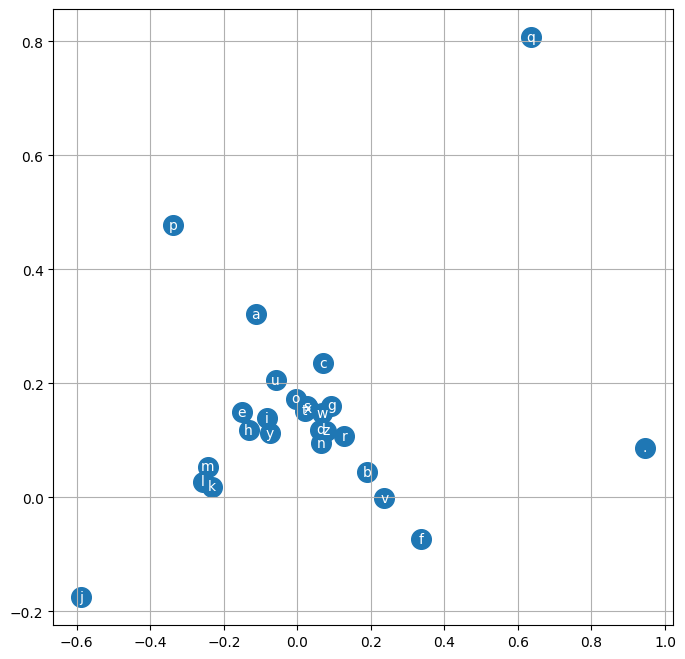

In [95]:
plt.figure(figsize = (8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), index_to_string[i], ha = 'center', va = 'center', color = 'white')
plt.grid('minor')

In [97]:

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break


    print(''.join(index_to_string[i] for i in out))

mie.
kasiani.
kari.
pano.
caiyl.
anya.
resisaha.
akayki.
aldan.
mabreel.
rosana.
augh.
adda.
tyt.
keap.
eson.
rae.
nomahra.
zera.
arianna.
